# Final TP

- XGBoost and AdaBoost

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne

from collections import Counter
from itertools import product

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import LogNorm

from mne.datasets.sleep_physionet.age import fetch_data

import epoch
from createFeatures import create_features_recording_session

In [11]:
"""
psg_data
    The psg_data variable contains polysomnography data, which typically includes multiple physiological signals such as EEG, EOG, and EMG, recorded during sleep.

hypnogram_data
    The hypnogram_data variable represents annotations or labels associated with sleep stages, providing information about the temporal distribution of wakefulness, different sleep stages (NREM and REM), and transitions during a sleep recording.
    
fs 
    represents the sampling frequency (or sampling rate) of the polysomnography (PSG) data, indicating the number of samples per second in the signal.
"""

# Reading data (psg) and hypnogram (labels)
psg_file = "data/SC4001E0-PSG.edf"
hypnogram_file = "data/SC4001EC-Hypnogram.edf"

# psg_data = mne.io.read_raw_edf(psg_file)
# hypnogram_data = mne.read_annotations(hypnogram_file)

In [12]:
s = epoch.sleepRecording()
s.init_from_file("data/SC4001E0-PSG.edf", "data/SC4001EC-Hypnogram.edf")

Extracting EDF parameters from /Users/stig/Desktop/- TU:e/5Q1 ITBA Buenos Aires/72.75 Aprendizarje Automatico/72.75-ML/final/data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/stig/Desktop/- TU:e/5Q1 ITBA Buenos Aires/72.75 Aprendizarje Automatico/72.75-ML/final/epoch.py:117: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  psg_data_raw.set_annotations(hypnogramm_annotations)


In [13]:
# Checking how much of each label we have in the dataset

label_list = [s.epochs[i].label for i in range(len(s.epochs))]
label_counts = Counter(label_list)
for label, count in label_counts.items():
    print(f"{label}: {count}")

Sleep stage W: 1997
Sleep stage 1: 58
Sleep stage 2: 250
Sleep stage 3: 101
Sleep stage 4: 119
Sleep stage R: 125


In [14]:
s.epochs[10].ch_names

['EEG Fpz-Cz',
 'EEG Pz-Oz',
 'EOG horizontal',
 'Resp oro-nasal',
 'EMG submental',
 'Temp rectal',
 'Event marker']

In [29]:
FREQ_BANDS = {'SO':[0.5, 1],
            'delta': [1, 4],
            'theta': [4, 8],
            'alpha': [8, 13],
            'sigma': [13,15],
            'beta': [15, 30],
            'gamma': [30, 60]}

# Applying feature extraction functions to each epoch
create_features_recording_session(s)

# Initialize lists for features and labels
features = []
labels = []

# Iterate over each epoch to gather features and labels
for e in s.epochs:
    # Extract the features for the current epoch
    feature_row = [e.features[f'integral_{band}_Pz-Oz'] for band in FREQ_BANDS] + \
                  [e.features[f'integral_{band}_Fpz-Cz'] for band in FREQ_BANDS] + \
                  [e.features['avg_temp']]
    
    # Append the feature row and label to their respective lists
    features.append(feature_row)
    labels.append(e.label)

# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels)

# Handling missing values (if any)
# Example: Replace NaNs with the mean of the respective column
X = np.nan_to_num(X, nan=np.nanmean(X))

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the label encoder. Fit the label encoder and transform the labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

X_train.shape

(2120, 15)

In [32]:
# Define hyperparameters
hyperparameters = {
    'n_estimators': 100,        # Number of trees - start with a moderate number
    'learning_rate': 0.1,       # Learning rate - start with a default value
    'max_depth': 3,             # Moderate depth to control overfitting
    'subsample': 0.8,           # Use 80% of data to fit each tree
    'colsample_bytree': 0.8,    # Use 80% of features for each tree
    'gamma': 0.1,           # Minimum loss reduction required to make a further partition
    'reg_lambda': 1,            # L2 regularization term
    'reg_alpha': 0.1            # L1 regularization term
}

# Create an XGBoost classifier
xgb_clf = XGBClassifier(**hyperparameters)

# Create a pipeline
pipeline = Pipeline([
    ('classifier', xgb_clf)
])

# Fit the model
pipeline.fit(X_train, y_train)


Test Accuracy: 0.9434


In [47]:
# Evaluate the model
accuracy = pipeline.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
predictions = pipeline.predict(X_test)

Test Accuracy: 0.9434


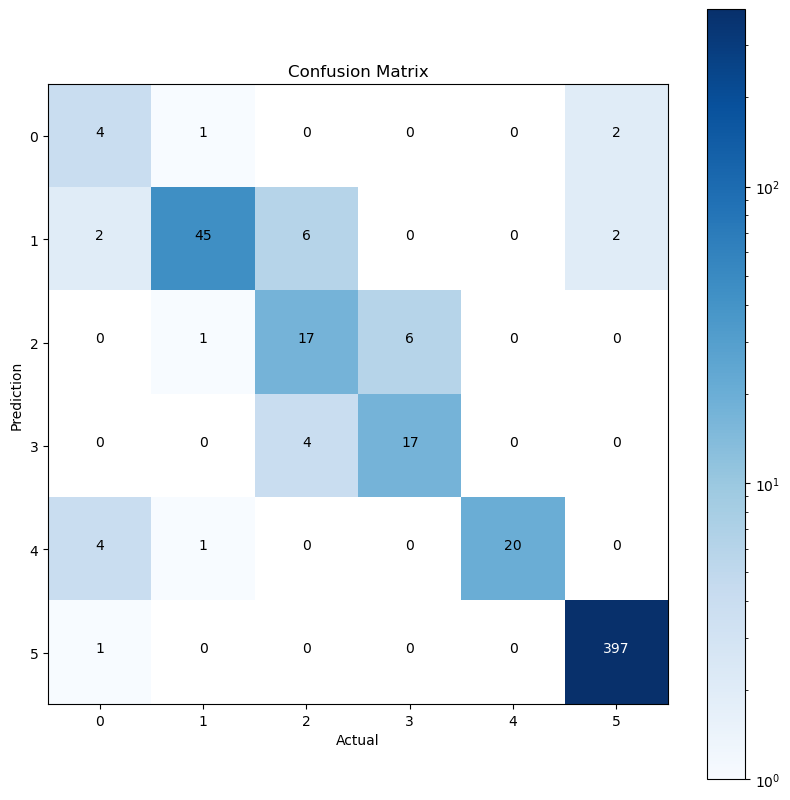

In [50]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))

# Use LogNorm for color scale
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues, norm=LogNorm())

plt.title('Confusion Matrix')
plt.colorbar()

# Labels for the plot axis
thresh = conf_matrix.max() / 2.
for i, j in product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

# Gridsearch

In [52]:
# Define a parameter grid to search over
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__gamma': [0.1, 0.2, 0.3],
    'classifier__reg_lambda': [0.5, 1, 1.5],
    'classifier__reg_alpha': [0.1, 0.2, 0.3]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)
